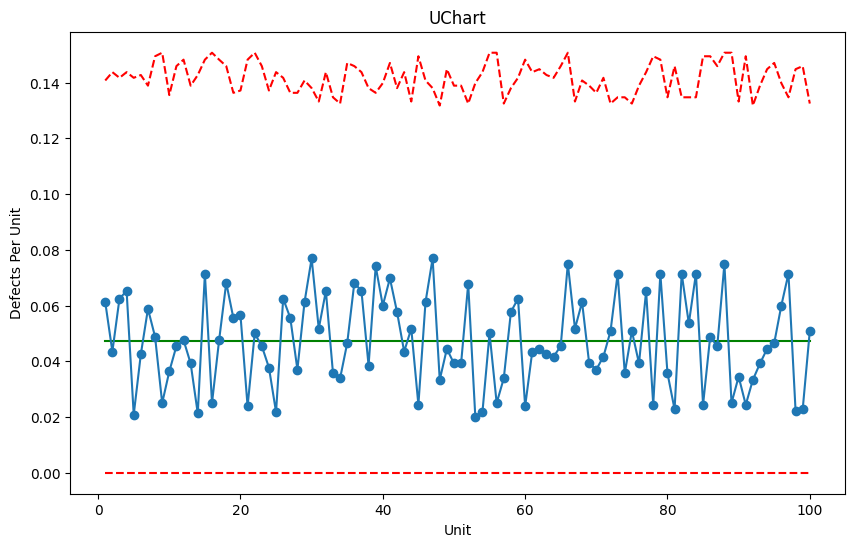

In [2]:
import pandas as pd
from spc_toolbox import UChart

df = pd.read_csv("data/UChart.csv")

uChart = UChart()

uChart.fit(index=df["Unit"], values=df["Defects"], sample_sizes=df["SampleSize"], z=3.0)
uChart.plot()

,rule_one_point_gt_3_sigma,rule_9_points_in_a_row_on_the_same_side_of_center_line,rule_6_points_in_a_row_continuously_increasing_or_decreasing,rule_14_points_in_a_row_alternating_up_and_down
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
95,False,False,True,False
96,False,False,True,False
97,False,False,False,False
98,False,False,False,False


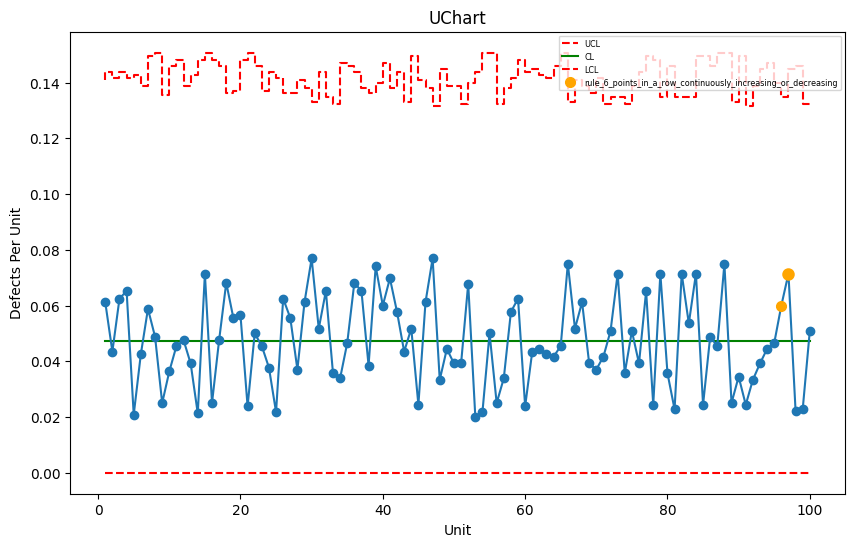

In [1]:
from spc_toolbox import ControlChart
import numpy as np
import pandas as pd
from spc_toolbox import UChart

df = pd.read_csv("data/UChart.csv")

uChart = UChart()

uChart.fit(index=df["Unit"], defects=df["Defects"], sample_sizes=df["SampleSize"], z=3.0)

def rule_one_point_gt_k_sigma(chart: ControlChart, k: float) -> pd.Series:
    deviation = chart.y - chart.center_line
    return deviation.abs() > (chart.sigma * k)

def rule_k_points_same_side(chart: ControlChart, k: int) -> pd.Series:
    side = (chart.y > chart.center_line).astype(int)
    return side.rolling(window=k).sum().isin([0, k])

def rule_k_points_all_increasing_or_decreasing(chart: ControlChart, k: int) -> pd.Series:
    diff = chart.y.diff()
    increasing = (diff > 0).astype(int).rolling(window=k-1).sum() == (k-1)
    decreasing = (diff < 0).astype(int).rolling(window=k-1).sum() == (k-1)
    return increasing | decreasing

def rule_k_points_alternating(chart: ControlChart, k: int) -> pd.Series:
    diff = chart.y.diff().fillna(0)
    signs = diff.apply(np.sign)
    alternates = signs != signs.shift()
    return alternates.rolling(window=k).sum() == k


rules = {
    "rule_one_point_gt_3_sigma": lambda chart: rule_one_point_gt_k_sigma(chart, 3),
    "rule_9_points_in_a_row_on_the_same_side_of_center_line": lambda chart: rule_k_points_same_side(chart, 9),
    "rule_6_points_in_a_row_continuously_increasing_or_decreasing": lambda chart: rule_k_points_all_increasing_or_decreasing(chart, 6),
    "rule_14_points_in_a_row_alternating_up_and_down": lambda chart: rule_k_points_alternating(chart, 14),
}

uChart.add_rules(rules)
uChart.plot()

results = uChart.evaluate_rules(rules)
results_df = pd.DataFrame(results)
results_df